In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors

import constants
import pandas as pd
import pyVHR.analysis.pipelineLandmarks as custom_pipeline

vhr.plot.VisualizeParams.renderer = 'vscode' 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
from numpy.lib.arraysetops import isin
import pandas as pd
import numpy as np
from importlib import import_module, util
from pyVHR.datasets.dataset import datasetFactory
from pyVHR.utils.errors import getErrors, printErrors, displayErrors, BVP_windowing
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
from inspect import getmembers, isfunction
from pyVHR.deepRPPG.mtts_can import *
from pyVHR.deepRPPG.hr_cnn import *
from pyVHR.extraction.utils import *
# import dtaidistance
import dtw
import scipy
from itertools import chain, combinations
import steps

from tqdm import tqdm

In [3]:
# -- LOAD A DATASET

dataset_name = 'mr_nirp' 
brightness = 'roi_80'
activity = 'rotation'
SAMPLING = '2000'
videoFPS, sigFPS = constants.get_fps(dataset_name)

dataset = steps.get_dataset(dataset_name)
# dataset = steps.gset_dataset(dataset_name, video_DIR=f'D:/datasets_rppg/brightness_roi/{brightness}/{dataset_name.upper()}')
allvideo = dataset.videoFilenames
videos = constants.get_video_settings(dataset_name)
print(videos)

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

{'MOTION': [0, 2, 4, 6, 9, 11, 13], 'STILL': [1, 3, 5, 7, 8, 10, 12, 14], 'MALE': [0, 1, 4, 5, 6, 7, 8, 9, 10, 13, 14], 'FEMALE': [2, 3, 11, 12], 'BEARD': [0, 1, 4, 5, 8, 9, 10, 13, 14], 'DARK': [0, 1, 2, 3, 4, 5, 13, 14]}
0 D:/datasets_rppg/MR-NIRP_indoor\Subject1_motion_940\Subject1_motion_940\RGB_corrected\Subject1_motion_940.avi
1 D:/datasets_rppg/MR-NIRP_indoor\Subject1_still_940-015\Subject1_still_940\RGB_corrected\Subject1_still_940.avi
2 D:/datasets_rppg/MR-NIRP_indoor\Subject2_motion_940\Subject2_motion_940\RGB_corrected\Subject2_motion_940.avi
3 D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
4 D:/datasets_rppg/MR-NIRP_indoor\Subject3_motion_940\Subject3_motion_940\RGB_corrected\Subject3_motion_940.avi
5 D:/datasets_rppg/MR-NIRP_indoor\Subject3_still_940-012\Subject3_still_940\RGB_corrected\Subject3_still_940.avi
6 D:/datasets_rppg/MR-NIRP_indoor\Subject4_motion_940\Subject4_motion_940\RGB_corrected\Subject4_motio

videoFileName :  D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T1.avi
Video frame rate:      35.138
Length of the video: 1:05 min, timesGT is 180 s
Signal frame rate is 60 fps for MR-NIRP and signal is  180.0 seconds worth


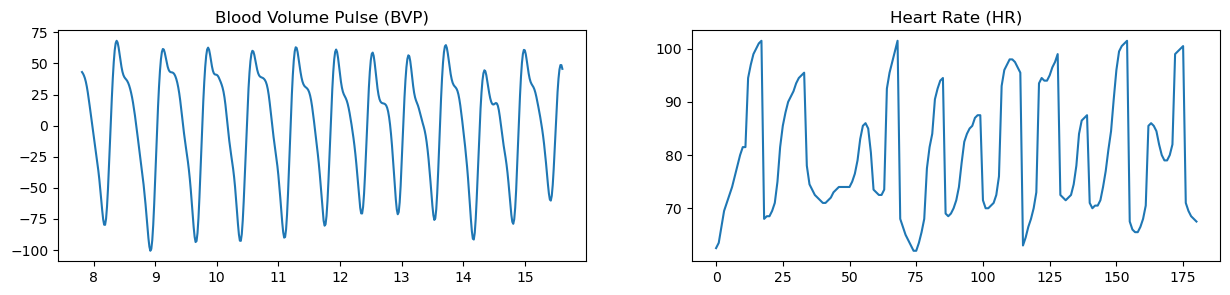

In [52]:
# -- PARAMETER SETTING

videoIdx = 0
winsize = 10        # seconds of video processed (with overlapping) for each estimate 
fname = dataset.getSigFilename(videoIdx)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(winsize) # STFT 42-240 BPM
videoFileName = dataset.getVideoFilename(videoIdx)
fps = vhr.extraction.get_fps(videoFileName)
print("videoFileName : ", videoFileName)

fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)
print(f"Length of the video: 1:05 min, timesGT is {len(timesGT)-1} s")
print("Signal frame rate is 60 fps for MR-NIRP and signal is ", sigGT.data.shape[1] / sigFPS, "seconds worth")

fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(np.arange(0, len(timesGT), 1/sigFPS)[500:1000], sigGT.data.T[500:1000])
ax[0].set_title('Blood Volume Pulse (BVP)')
ax[1].plot(timesGT, bpmGT)
ax[1].set_title('Heart Rate (HR)')
plt.show()

# Extract windows

In [53]:
winsize = 10
overlap = 0 
duration = 60

In [54]:
df = pd.read_hdf(f'../results/no_overlap/{dataset_name.upper()}/{dataset_name.upper()}_rPPG.h5', key='df')
# df = pd.read_hdf(f'../results/brightness_{brightness}/{dataset_name.upper()}/{dataset_name.upper()}_rPPG.h5', key='df')
# df = pd.read_hdf(f'../results/brightness_roi/{brightness}/{dataset_name.upper()}/{dataset_name.upper()}_rPPG.h5', key='df')
# df = pd.read_hdf(f'../results/brightness_roi/{brightness}/{dataset_name.upper()}_rPPG.h5', key='df')


print(brightness)
print(f"Single landmark: {df['landmark'].unique().size}")
print(f"Dataset {df['dataset'].unique()} with {df['videoFilename'].unique().size} files" )
print("Sampling: ", SAMPLING, df['sampling'].unique()) 
print("Extracted video lenghth: ", len(df.loc[0, 'rPPG']) / videoFPS, "seconds")
df.head()

roi_80
Single landmark: 28
Dataset ['ubfc_phys'] with 56 files
Sampling:  2000 ['2000']
Extracted video lenghth:  180.00455347487053 seconds


,dataset,videoIdx,videoFilename,landmark,bpmGT,rPPG,timesGT,timesES,sampling
0,ubfc_phys,0,s1,lower_medial_forehead,"[61.0, 62.50000000000001, 67.0, 69.5, 71.0, 72...","[[[138.0545, 107.526, 73.941]], [[136.6025, 10...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
1,ubfc_phys,0,s1,left_lower_lateral_forehead,"[61.0, 62.50000000000001, 67.0, 69.5, 71.0, 72...","[[[141.177, 109.5445, 77.151]], [[140.4745, 10...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
2,ubfc_phys,0,s1,right_lower_lateral_forehead,"[61.0, 62.50000000000001, 67.0, 69.5, 71.0, 72...","[[[153.5565, 123.277, 94.4635]], [[154.364, 12...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
3,ubfc_phys,0,s1,glabella,"[61.0, 62.50000000000001, 67.0, 69.5, 71.0, 72...","[[[148.668, 115.943, 88.522]], [[148.9035, 116...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000
4,ubfc_phys,0,s1,upper_nasal_dorsum,"[61.0, 62.50000000000001, 67.0, 69.5, 71.0, 72...","[[[163.551, 122.333, 94.398]], [[162.7585, 122...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",None,2000


In [55]:
class TestResult():
    """ 
    This class manages the results on a given dataset using multiple rPPG methods.
    """

    def __init__(self, filename=None):

        if filename == None:
            self.dataFrame = pd.DataFrame()
        else:
            self.dataFrame = pd.read_hdf(filename)
        self.dict = None

    def addDataSerie(self):
        # -- store serie
        if self.dict != None:
            self.dataFrame = self.dataFrame._append(self.dict, ignore_index=True)
            # self.dataFrame = self.dataFrame.append(self.dict, ignore_index=True)

    def newDataSerie(self):
        # -- new dict
        D = {}
        D['method'] = ''
        D['dataset'] = ''
        D['videoIdx'] = ''        # video filename
        D['videoFilename'] = ''   # GT signal filename
        D['bpmGT'] = ''             # GT bpm
        D['bpmES'] = ''
        D['timeGT'] = ''            # GT bpm
        D['timeES'] = ''
        D['BVP_win'] = ''
        D['landmarks'] = ''
        self.dict = D


    def addData(self, key, value):
        self.dict[key] = value

    def saveResults(self, outFilename=None):
        """
        Save the test results in a HDF5 library that can be opened using pandas.
        You can analyze the results using :py:class:`pyVHR.analysis.stats.StatAnalysis`
        """
        if outFilename is None:
            outFilename = "testResults.h5"
        else:
            self.outFilename = outFilename

        # -- save data
        self.dataFrame.to_hdf(outFilename, key='self.dataFrame', mode='w')

def get_bpm(res, videoFileName, landmarks, windowed_sig,
            timesES, bpmGT, timesGT, PPG_win, videoFPS, sigFPS, dataset_name,
            cuda=True, 
            roi_method='convexhull', 
            roi_approach='landmark', 
            methods=['cupy_CHROM', 'cpu_LGI'], 
            estimate='median', 
            movement_thrs=[10, 5, 2],
            patch_size=30, 
            RGB_LOW_HIGH_TH = (0,240),
            Skin_LOW_HIGH_TH = (0, 240),
            pre_filt=True, 
            post_filt=True, 
            winsize = 10,
            verb=False):
    
    minHz = 0.65
    maxHz = 4.0
    fps = videoFPS

    ## 5. PRE FILTERING
    filtered_windowed_sig = windowed_sig

    if pre_filt:
        module = import_module('pyVHR.BVP.filters')
        method_to_call = getattr(module, 'BPfilter')
        filtered_windowed_sig = apply_filter(filtered_windowed_sig,
                                                method_to_call, 
                                                fps=fps, 
                                                params={'minHz':minHz, 
                                                        'maxHz':maxHz, 
                                                        'fps':'adaptive', 
                                                        'order':6})

    ## 6. BVP extraction multimethods
    bvps_win = []
    for method in methods:
        # try:
        if verb:
            print(" - Extraction method: " + method)
        module = import_module('pyVHR.BVP.methods')
        method_to_call = getattr(module, method)
        
        if 'cpu' in method:
            method_device = 'cpu'
        elif 'torch' in method:
            method_device = 'torch'
        elif 'cupy' in method:
            method_device = 'cuda'

        if 'POS' in method:
            pars = {'fps':'adaptive'}
        elif 'PCA' in method or 'ICA' in method:
            pars = {'component': 'all_comp'}
        else:
            pars = {}

        bvps_win = RGB_sig_to_BVP(filtered_windowed_sig, 
                                fps, device_type=method_device, 
                                method=method_to_call, params=pars)

        ## 7. POST FILTERING
        if post_filt:
            module = import_module('pyVHR.BVP.filters')
            method_to_call = getattr(module, 'BPfilter')
            bvps_win = apply_filter(bvps_win, 
                                method_to_call, 
                                fps=fps, 
                                params={'minHz':minHz, 'maxHz':maxHz, 'fps':'adaptive', 'order':6})

        ## 8. BPM extraction

        if roi_approach == 'holistic':
            if cuda:
                bpmES = BVP_to_BPM_cuda(bvps_win, fps, minHz=minHz, maxHz=maxHz)
            else:
                bpmES = BVP_to_BPM(bvps_win, fps, minHz=minHz, maxHz=maxHz)

        elif roi_approach == 'patches' or roi_approach == 'landmark':
            if estimate == 'clustering':
                #if cuda and False:
                #    bpmES = BVP_to_BPM_PSD_clustering_cuda(bvps_win, fps, minHz=minHz, maxHz=maxHz)
                #else:
                #bpmES = BPM_clustering(sig_processing, bvps_win, winsize, movement_thrs=[15, 15, 15], fps=fps, opt_factor=0.5)
                ma = MotionAnalysis(sig_processing, winsize, fps)
                bpmES = BPM_clustering(ma, bvps_win, fps, winsize, movement_thrs=movement_thrs, opt_factor=0.5)
                
            elif estimate == 'median':
                if cuda:
                    bpmES = BVP_to_BPM_cuda(bvps_win, fps, minHz=minHz, maxHz=maxHz)
                else:
                    bpmES = BVP_to_BPM(bvps_win, fps, minHz=minHz, maxHz=maxHz)
        else:
            raise ValueError("Estimation approach unknown!")
        
        # -- save results
        res.newDataSerie()
        res.addData('method', str(method))
        res.addData('bpmGT', bpmGT)
        res.addData('bpmES', bpmES) # before aggregating of left and right
        res.addData('timeGT', timesGT)
        res.addData('timeES', timesES)
        res.addData('BVP_win', bvps_win)
        res.addData('videoFilename', videoFileName)
        res.addData('landmarks', tuple(landmarks))
        res.addDataSerie()
        
    return res, bvps_win

In [56]:
case = 'each_28'
all_landmarks, landmarks_keys = steps.get_landmarks(case)

In [57]:
all_landmarks = [['soft_triangle']]

In [58]:
import steps 
res = TestResult()

# for videoIdx in tqdm(range(len(allvideo))):
# for fileIdx in tqdm(videos['STILL']):
for videoIdx in tqdm(df.videoIdx.unique()):
# for fileIdx in tqdm(videos['STILL'][:1]):
    try:
        # videoIdx = allvideo.index(allvideo[fileIdx])
        fps = get_fps(allvideo[videoIdx])
        PPG_win, bpmGT, timesGT, videoFileName = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize)
    except Exception as e:
        print(f"Error in {videoIdx} {videoFileName}: {e}")
        continue

    # for landmarks in all_landmarks[:2]:
    for landmarks in all_landmarks:
        try:        
            rppgs = df.loc[(df['videoFilename'] == videoFileName) & (df['landmark'].isin(landmarks)), 'rPPG',].tolist()
            for i,rppg in enumerate(rppgs): # windowing
                rppgs[i], timesES = steps.sig_windowing(rppgs[i], winsize, winsize-overlap, fps)

            windowed_sig = np.concatenate([rppg for rppg in rppgs], axis=1)
            windowed_sig = windowed_sig[:int(duration/winsize)] # only take duration length, here 60s
            timesES = timesES[:int(duration/winsize)] # only take duration length, here 60s

            res, _ = get_bpm(res, videoFileName, landmarks, windowed_sig, timesES, bpmGT, timesGT, PPG_win, fps, sigFPS, dataset_name, roi_approach='landmark', methods=['cupy_CHROM'])
        except Exception as e:
            print(f"Error in {videoIdx} {videoFileName}: {e}")
            continue
            
res.dataFrame['dataset'] = dataset_name
    

  2%|▏         | 1/56 [00:00<00:06,  8.48it/s]

100%|██████████| 56/56 [00:03<00:00, 15.37it/s]


In [59]:
windowed_sig = np.concatenate([rppg for rppg in rppgs], axis=1)
print(windowed_sig.shape)
rppgs = df.loc[(df['videoFilename'] == videoFileName) & (df['landmark'].isin(landmarks)), 'rPPG',].tolist()
print(len(rppgs[0]))

(18, 1, 3, 352)
6325


In [63]:
# print(len(df_res.BVP_win.iloc[0]))
print(df.rPPG.iloc[0].shape)

(6325, 1, 3)


In [61]:
df_res = res.dataFrame
rois = constants.get_rois()
for roi in list(rois.keys()):
    df_res.loc[df_res['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'ROI'] = roi

indexes = {}
for v in range(len(allvideo)):
  if dataset_name == 'lgi_ppgi':
    indexes[allvideo[v].split('\\')[-2]] = v
  elif dataset_name == 'ubfc_phys':
    if 'T1' not in allvideo[v]: continue  
    indexes[allvideo[v].split('\\')[-1].split('_')[1]] = v 
  elif dataset_name == 'mr_nirp':
    indexes[allvideo[v].split('\\')[-1][:-4]] = v
indexes = pd.DataFrame({'videoIdx':list(indexes.values()), 'videoFilename':list(indexes.keys())})
df_res = df_res.drop(columns=['videoIdx'])
df_res.insert(3, 'videoIdx', df_res['videoFilename'].map(indexes.set_index('videoFilename')['videoIdx']))

df_res['SAMPLING'] = SAMPLING
df_res['winsize'] = winsize
df_res['overlap'] = overlap
print(f"Single landmark: {df_res['landmarks'].unique().size}")
print(f"Dataset {df_res['dataset'].unique()} with {df_res['videoFilename'].unique().size} files" )
df_res.head()

Single landmark: 1
Dataset ['ubfc_phys'] with 56 files


C:\Users\erolland\AppData\Local\Temp\3\ipykernel_17380\150667606.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'forehead' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_res.loc[df_res['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'ROI'] = roi


,method,dataset,videoFilename,videoIdx,bpmGT,bpmES,timeGT,timeES,BVP_win,landmarks,ROI,SAMPLING,winsize,overlap
0,cupy_CHROM,ubfc_phys,s1,0,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[67.94261718749999, 81.32525390624998, 66.9131...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.006425700867116336, 0.15621653179760964,...","(soft_triangle,)",nose,2000,10,0
1,cupy_CHROM,ubfc_phys,s10,3,"[85.0, 86.0, 89.0, 92.5, 92.5, 92.5, 91.0, 88....","[91.61958984374999, 92.64902343749999, 91.6195...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.03433476491434677, 0.36483449396670015, ...","(soft_triangle,)",nose,2000,10,0
2,cupy_CHROM,ubfc_phys,s11,6,"[77.5, 78.0, 79.5, 81.0, 82.0, 82.0, 82.0, 82....","[81.32525390624998, 85.44298828125, 52.5011132...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.01696752893274234, 0.5377378401346886, 0....","(soft_triangle,)",nose,2000,10,0
3,cupy_CHROM,ubfc_phys,s12,9,"[88.0, 87.5, 86.0, 84.5, 84.0, 83.0, 82.0, 80....","[82.3546875, 82.3546875, 92.64902343749999, 90...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.0005834887907782977, 0.1902430390052677,...","(soft_triangle,)",nose,2000,10,0
4,cupy_CHROM,ubfc_phys,s13,12,"[76.5, 77.0, 79.5, 83.5, 85.5, 87.0, 87.5, 88....","[84.4135546875, 91.61958984374999, 97.79619140...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.07961068923962054, 0.5948158004593579, 1...","(soft_triangle,)",nose,2000,10,0


In [62]:
# path = f'../results/no_overlap/{dataset_name.upper()}/'
# path = f'../results/brightness_{brightness}/{dataset_name.upper()}/'
# path = f'../results/brightness_roi/{brightness}/{dataset_name.upper()}/'
path = f'../results/brightness_roi/{brightness}/'


filenames = {'each_28':'28', 'each_18':'18', 'all_in_roi':'entire_ROI', 'combine_random_landmarks':'combine_2_landmarks', 'combine_roi_landmarks':'landmarks_in_roi', 'combine_roi':'combine_ROI'}
# filenames['combine_random_landmarks'] = f"combine_3-5_landmarks"
filename = path+f'{dataset_name.upper()}_BVP28.h5'

print(filename)
df_res.to_hdf(filename, key='df', mode='w')

../results/brightness_roi/roi_80/UBFC_PHYS_BVP28.h5


C:\Users\erolland\AppData\Local\Temp\3\ipykernel_17380\2598109828.py:12: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['method', 'dataset', 'videoFilename', 'bpmGT', 'bpmES', 'timeGT',
       'timeES', 'BVP_win', 'landmarks', 'ROI', 'SAMPLING'],
      dtype='object')]

  df_res.to_hdf(filename, key='df', mode='w')


# Evaluate

In [64]:
duration = 60

In [65]:
elements = ['lower_lateral_forehead', 'marionette_fold', 'chin', 'lower_medial_forehead', 'upper_nasal_dorsum', 'soft_triangle', 'glabella', 'malar', 'lower_cheek']
t = steps.get_landmarks_combination(elements, min_len=2, max_len=5)
len(t)

elements = ['left_malar', 'right_malar', 'left_lower_cheek', 'right_lower_cheek', 'soft_triangle', 'upper_nasal_dorsum',
 'lower_medial_forehead', 'glabella', 'left_lower_lateral_forehead', 'right_lower_lateral_forehead', 'left_marionette_fold',  'right_marionette_fold' ]

elements = ['left_malar',
 'right_malar',
 'soft_triangle',
 'upper_nasal_dorsum',
 'lower_medial_forehead',
 'glabella',
 'left_lower_lateral_forehead',
 'right_lower_lateral_forehead',
 'nasal_tip'
 ]

In [66]:
# Landmarks choice
case = 'combine_random_landmarks'
cases = ['each_28', 'each_18', 'all_in_roi', 'combine_random_landmarks', 'combine_roi_landmarks', 'combine_roi']
# elements = sum([rois[roi] for roi in ['forehead', 'nose', 'cheeks',]], [])
if case == 'combine_random_landmarks':
    rois = constants.get_rois()
    all_landmarks_names = vhr.extraction.utils.CustomLandmarks().get_all_landmarks()
    elements = {i: all_landmarks_names[i] for i in elements}
    all_landmarks, landmarks_keys = steps.get_landmarks(case, min_len=2, max_len=11, all_landmarks_names=elements, rois=None)
else:
    all_landmarks, landmarks_keys = steps.get_landmarks(case)
print(f"Chosen_landmarks: {len(all_landmarks)}, {all_landmarks}")

# Check extraction configuration
config = f'{SAMPLING}_win10-0'
overlap = int(config[-1])
winsize = int(config.split('_')[1].split('-')[0][3:])
length = int((duration - winsize) / (winsize - overlap)) + 1
print(f"Overlap: {overlap}, Winsize: {winsize}, Duration: {duration}, Length: {length}")
print("Case: ", case)    

Chosen_landmarks: 120, [{'right_lower_lateral_forehead', 'upper_nasal_dorsum', 'left_lower_lateral_forehead'}, {'right_lower_lateral_forehead', 'left_lower_lateral_forehead', 'soft_triangle'}, {'left_malar', 'left_lower_lateral_forehead', 'right_malar', 'right_lower_lateral_forehead'}, {'right_lower_lateral_forehead', 'left_lower_lateral_forehead', 'glabella'}, {'right_lower_lateral_forehead', 'left_lower_lateral_forehead', 'nasal_tip'}, {'right_lower_lateral_forehead', 'left_lower_lateral_forehead', 'lower_medial_forehead'}, {'upper_nasal_dorsum', 'soft_triangle'}, {'left_malar', 'upper_nasal_dorsum', 'right_malar'}, {'upper_nasal_dorsum', 'glabella'}, {'upper_nasal_dorsum', 'nasal_tip'}, {'upper_nasal_dorsum', 'lower_medial_forehead'}, {'left_malar', 'soft_triangle', 'right_malar'}, {'soft_triangle', 'glabella'}, {'soft_triangle', 'nasal_tip'}, {'soft_triangle', 'lower_medial_forehead'}, {'left_malar', 'right_malar', 'glabella'}, {'left_malar', 'right_malar', 'nasal_tip'}, {'left_mal

In [67]:
# all_landmarks = [landmarks for landmarks in all_landmarks if 'soft_triangle' in landmarks]
all_landmarks = [{'glabella', 'left_malar', 'right_malar', 'soft_triangle'}]
print(len(all_landmarks))

1


In [69]:
# df = pd.read_hdf(f'../results/no_overlap/{dataset_name.upper()}/{config}/{dataset_name.upper()}_BVP28_{config}.h5', key='df')
df = pd.read_hdf(f'../results/no_overlap/{dataset_name.upper()}/{config}/{dataset_name.upper()}_BVP28.h5', key='df')
# df = pd.read_hdf(f'../results/brightness_{brightness}/{dataset_name.upper()}/{dataset_name.upper()}_BVP28.h5', key='df')
df_roi = pd.read_hdf(f'../results/brightness_roi/{brightness}/{dataset_name.upper()}_BVP28.h5', key='df')
df_roi = df_roi.loc[df_roi['landmarks'].apply(lambda x: 'soft_triangle' in x[0])].reset_index(drop=True)

df = df.query('method == "cupy_CHROM"').reset_index(drop=True)
df['RMSE'] = None
df['MAE'] = None
df['PCC'] = None
df['timePCC'] = None
df['timeDTW'] = None    
df['SNR'] = None
videoFPS, sigFPS = constants.get_fps(dataset_name)
print(df.method.unique())
df.head(1)

['cupy_CHROM']


,method,dataset,videoFilename,videoIdx,bpmGT,bpmES,timeGT,timeES,BVP_win,landmarks,ROI,SAMPLING,winsize,overlap,RMSE,MAE,PCC,timePCC,timeDTW,SNR
0,cupy_CHROM,ubfc_phys,s1,0,"[62.50000000000001, 63.5, 66.5, 69.5, 71.0, 72...","[64.85431640624999, 81.32525390624998, 66.9131...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.002213766263841168, -0.49858801686507914...","(lower_medial_forehead,)",forehead,2000,10,0,None,None,None,None,None,None


In [71]:
df['soft_triangle'] = df['landmarks'].apply(lambda x: 'soft_triangle' in x[0])
df_roi['soft_triangle'] = df_roi['landmarks'].apply(lambda x: 'soft_triangle' in x[0])
df = df.merge(df_roi[['videoFilename', 'videoIdx', 'landmarks', 'soft_triangle', 'BVP_win']], on=['videoFilename', 'videoIdx', 'landmarks', 'soft_triangle'], suffixes=('', '_roi'), how='left')
# fill rows where BVP_win_roi is NAN by values in BVP_win
df.loc[df['BVP_win_roi'].isna(), 'BVP_win_roi'] = df.loc[df['BVP_win_roi'].isna(), 'BVP_win']
df = df.drop(columns=['BVP_win', 'soft_triangle']).rename(columns={'BVP_win_roi':'BVP_win'})

In [72]:
def add_data(landmarks, videoFileName, videoIdx, method, RMSE, MAE, PCC, CC, DTW, SNR, bpmGT, bpmES, timesGT, timesES, BVP_win, dataset_name):
  
  data = {}
  data['dataset'] = dataset_name
  data['videoIdx'] = videoIdx
  data['videoFilename'] = videoFileName
  data['method'] = method
  data['landmarks'] = tuple(landmarks) # single landmark
  data['bpmGT'] = bpmGT
  data['bpmES'] = bpmES
  data['timeGT'] = timesGT
  data['timeES'] = timesES
  data['BVP_win'] = BVP_win
  data['RMSE'] = RMSE 
  data['MAE'] = MAE
  data['PCC'] = PCC
  data['timePCC'] = CC
  data['timeDTW'] = DTW
  data['SNR'] = SNR

  return data

In [73]:
import dtaidistance as dtwai

dataset = steps.get_dataset(dataset_name)
results = []
print("Landmarks: ", len(all_landmarks), case)

for videoIdx in tqdm(df.videoIdx.unique()):
# for fileIdx in tqdm(videos['STILL'][2:3]):
    try:
        # videoIdx = allvideo.index(allvideo[fileIdx])
        fps = get_fps(allvideo[videoIdx])
        PPG_win, bpmGT, timesGT, videoFileName = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize, winsize-overlap)

    except Exception as e:
        print(f"Error in GT {videoIdx} {videoFileName}: {e}")
        continue

    # for landmarks in all_landmarks[:2]:
    for landmarks in all_landmarks:
        # for method in df.method.unique():
        #     data = df.loc[df['method'] == method]
            # try:        
                # data = data.loc[(df['videoFilename'] == videoFileName) & (df['landmarks'].apply(lambda x: x[0] in landmarks)), ['timeES', 'bpmES', 'BVP_win']].iloc[0]       
                # timesES, bpmES, BVP_win = data['timeES'], data['bpmES'], data['BVP_win']
                # # Take the mean if there are multiple BVP estimates
                # BVP_agg = np.mean(BVP_win, axis=1) 
                # if bpmES[0].ndim > 0:
                #     bpmES = np.mean(bpmES, axis=1) 
                method = 'cupy_CHROM'
                data = df.loc[(df['videoFilename'] == videoFileName) & (df['landmarks'].apply(lambda x: x[0] in landmarks)), ['timeES', 'bpmES', 'BVP_win']]
                timesES, bpmES, BVP_win = data['timeES'].iloc[0], data['bpmES'].to_numpy(), data['BVP_win'].to_numpy()

                # Aggregate BVP and BPM
                BVP_agg = BVP_win
                for i,bvp_win in enumerate(BVP_win):
                    BVP_agg[i] = np.mean(bvp_win, axis=1) # take the mean in case the landmark is symmetrics
                BVP_agg = np.mean(BVP_agg, axis=0) # mean of all landmarks

                bpmES_agg = bpmES
                for i, bpm in enumerate(bpmES):
                    if np.array(bpm).ndim >1: # take the mean in case the landmark is symmetrics
                        bpmES_agg[i] = np.mean(bpm, axis=1)
                    else: # need to reduce the dimension
                        bpmES_agg[i] = np.array(bpm)
                bpmES_agg = np.mean(bpmES_agg, axis=0) # mean of all landmarks

                # BPM Error metrics
                RMSE, MAE, MAX, PCC, CCC, SNR = getErrors(BVP_win, videoFPS, bpmES_agg, bpmGT, timesES, timesGT)

                # BVP Error metrics
                PPG_win = np.array(PPG_win[:len(BVP_agg)]) # Take only 60s
                assert len(BVP_agg) == length
                BVP_agg = np.array([(bvps - np.min(bvps)) / (np.max(bvps) - np.min(bvps)) for bvps in BVP_agg])
                DTW = []
                CC = []
                for w in range(min(len(BVP_agg), len(PPG_win))):
                    dist = dtwai.dtw.distance(PPG_win[w], BVP_agg[w])
                    DTW.append(dist)
                    r, p = stats.pearsonr(PPG_win[w], BVP_agg[w])
                    CC.append(r)
                DTW = np.mean(DTW)
                CC = np.mean(CC)

                results.append(add_data(landmarks, videoFileName, videoIdx, method, RMSE, MAE, PCC, CC, DTW, SNR, bpmGT, bpmES_agg, timesGT, timesES, BVP_win, dataset_name))                    

            # except Exception as e:
            #     print(f"Error in {videoIdx} {videoFileName}: {e}")
            #     continue

Landmarks:  1 combine_random_landmarks


 16%|█▌        | 9/56 [00:10<00:55,  1.19s/it]

In [ ]:
df_res = pd.DataFrame(results)
rois = constants.get_rois()
if case == 'each_28' or case == 'each_18' or case == 'all_in_roi' or case == 'combine_roi_landmarks': 
  for roi in list(rois.keys()):
      df_res.loc[df_res['landmarks'].apply(lambda x: x[0]).isin(rois[f'{roi}']),'ROI'] = roi
if case == 'combine_roi': #### 5. combine ROI 
  for i,landmarks in enumerate(all_landmarks):
      df_res.loc[df_res['landmarks'] == tuple(landmarks),'ROI'] = landmarks_keys[i]
if case == 'combine_random_landmarks': #### combine random landmarks
  ldmk_roi = {landmark: roi for roi, landmarks in rois.items() for landmark in landmarks}
  df_res['ROI'] = df_res['landmarks'].apply(lambda x: '_'.join(set([ldmk_roi[landmark] for landmark in x])))
df_res['config'] = config
df_res.head()

,dataset,videoIdx,videoFilename,method,landmarks,bpmGT,bpmES,timeGT,timeES,BVP_win,RMSE,MAE,PCC,timePCC,timeDTW,SNR,ROI,config
0,lgi_ppgi,0,alex_gym,cupy_CHROM,"(left_malar, soft_triangle, right_malar, glabe...","[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[76.5380859375, 67.3828125, 117.73681640625, 8...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.06878939782788085, -1.723668941569227, -3...",[25.910477819756796],[23.870442708333332],[0.4534005678052802],0.060440,2.152949,[-4.862482026219368],nose_cheeks_forehead,2000_win10-0
1,lgi_ppgi,1,alex_resting,cupy_CHROM,"(left_malar, soft_triangle, right_malar, glabe...","[68.5, 68.0, 68.0, 67.5, 67.0, 67.0, 66.5, 66....","[68.4814453125, 77.45361328125, 95.947265625, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.07502738196441958, -0.6372189583643608, ...",[15.366675938060775],[11.827799479166666],[-0.38587751882852883],0.168887,1.853139,[-0.9375785639713285],nose_cheeks_forehead,2000_win10-0
2,lgi_ppgi,2,alex_rotation,cupy_CHROM,"(left_malar, soft_triangle, right_malar, glabe...","[67.5, 67.5, 68.0, 69.0, 69.5, 69.5, 69.5, 69....","[78.369140625, 70.12939453125, 62.255859375, 5...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.029454046478705004, -0.029519974249106858...",[9.194287649477939],[7.151692708333333],[-0.16280842661262546],0.085539,2.206718,[-2.467561550438404],nose_cheeks_forehead,2000_win10-0
3,lgi_ppgi,3,alex_talk,cupy_CHROM,"(left_malar, soft_triangle, right_malar, glabe...","[80.0, 67.0, 70.5, 73.0, 74.0, 75.0, 76.0, 77....","[101.62353515625, 93.93310546875, 77.087402343...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.06201688335718572, -0.16904705662419886, ...",[17.765093980836387],[14.7265625],[0.49239264275237926],0.196109,2.178421,[-3.022765312343836],nose_cheeks_forehead,2000_win10-0
4,lgi_ppgi,4,angelo_gym,cupy_CHROM,"(left_malar, soft_triangle, right_malar, glabe...","[71.0, 71.5, 72.0, 73.0, 73.5, 74.5, 76.0, 79....","[75.98876953125, 71.59423828125, 75.2563476562...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[0.09186689948562912, -1.777490894246028, -2...",[32.30086064395242],[25.487548828125],[0.03010599408548295],0.061414,2.145145,[-7.3224763199687],nose_cheeks_forehead,2000_win10-0


VideoFile:  harun_talk  landmarks:  {'left_malar', 'soft_triangle', 'right_malar', 'glabella'}


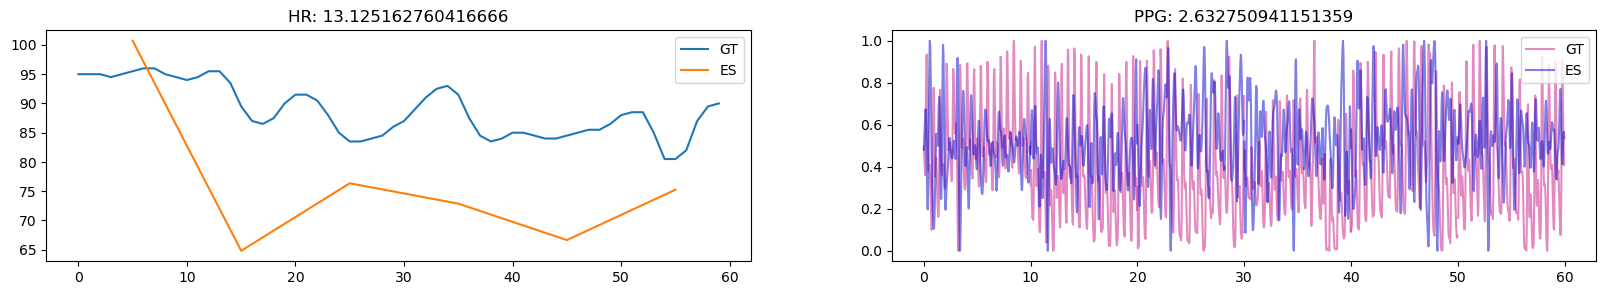

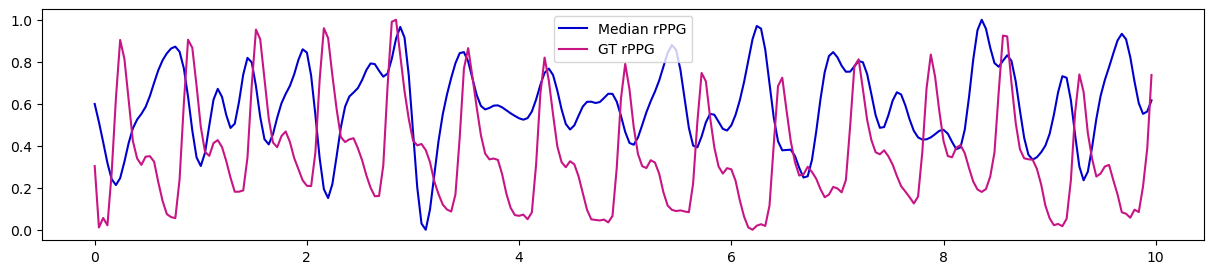

In [ ]:
print("VideoFile: ",videoFileName, " landmarks: ", landmarks)  
fig, ax = plt.subplots(1,2,figsize=(20,3))
ax[0].plot(timesGT[:60], bpmGT[:60],label='GT')
ax[0].plot(timesES, bpmES_agg, label='ES')
ax[0].set_title(f'HR: {MAE[0]}')
ax[0].legend()
for w in range(len(BVP_agg)):
    ax[1].plot(np.arange(timesES[w]-timesES.min(), timesES[w]+winsize -timesES.min(), 1/fps), PPG_win[w], alpha=0.5, color='mediumvioletred')
    ax[1].plot(np.arange(timesES[w]-timesES.min(), timesES[w]+winsize -timesES.min(), 1/fps), BVP_agg[w], alpha=0.5, color='mediumblue')
ax[1].plot([], [], label='GT', alpha=0.5, c='mediumvioletred')  
ax[1].plot([], [], label='ES', alpha=0.5, c='mediumblue') 
ax[1].set_title(f'PPG: {dist}')
ax[1].legend()
plt.show()

plt.figure(figsize=(15,3))
w = 2
plt.plot(np.arange(0, winsize, 1/len(BVP_agg[w])*winsize), BVP_agg[w], label='Median rPPG', c='mediumblue')
plt.plot(np.arange(0, winsize, 1/len(BVP_agg[w])*winsize),PPG_win[w], label='GT rPPG', c='mediumvioletred')
plt.legend()

In [ ]:
# path = f'../results/no_overlap/{dataset_name.upper()}/{config}/'
path = f'../results/brightness_roi/{brightness}/'
filenames = {'each_28':'28', 'each_18':'18', 'all_in_roi':'entire_ROI', 'combine_random_landmarks':'combine_landmarks', 'combine_roi_landmarks':'landmarks_in_roi', 'combine_roi':'combine_ROI'}

filename = path+f'{dataset_name.upper()}_GMS.h5'

print(filename)
df_res.to_hdf(filename, key='df', mode='w')

../results/brightness_roi/roi_80/LGI_PPGI_GMS.h5


C:\Users\erolland\AppData\Local\Temp\3\ipykernel_17380\18330069.py:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['dataset', 'videoFilename', 'method', 'landmarks', 'bpmGT', 'bpmES',
       'timeGT', 'timeES', 'BVP_win', 'RMSE', 'MAE', 'PCC', 'SNR', 'ROI',
       'config'],
      dtype='object')]

  df_res.to_hdf(filename, key='df', mode='w')
